In [14]:
import pdfplumber
import glob
import os
import docx2txt
from sklearn.feature_extraction.text import (
    CountVectorizer,
)
import pandas as pd
import numpy as np
import stopwordsiso as stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.dpi"] = 600

In [2]:
countries = [
    "Albania",
    "Belgium",
    "Bulgaria",
    "Canada",
    "Croatia",
    "Czech Republic",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Turkey",
    "United Kingdom",
    "United States",
]

corpus_df = pd.DataFrame(columns=["Country", "Document", "Text"])

In [3]:
for country in countries:
    pdfs = glob.glob(os.getcwd() + f"/documents/{country}/" + "*.pdf")
    docxs = glob.glob(os.getcwd() + f"/documents/{country}/" + "*.docx")
    for file in pdfs + docxs:
        if ".pdf" in file:
            with pdfplumber.open(file) as pdf:
                text = "".join(
                    [page.extract_text_simple().replace("\n", "") for page in pdf.pages]
                )
                corpus_df.loc[len(corpus_df), "Country"] = country
                corpus_df.loc[len(corpus_df), "Document"] = file[file.rfind("/") + 1 :]
                corpus_df.loc[len(corpus_df), "Text"] = text
        else:
            text = docx2txt.process(file).replace("\n", "")
            corpus_df.loc[len(corpus_df), "Country"] = country
            corpus_df.loc[len(corpus_df), "Document"] = file[file.rfind("/") + 1 :]
            corpus_df.loc[len(corpus_df), "Text"] = text

In [4]:
corpus_df.to_csv("./corpus.csv", index=False, escapechar="\\")

In [6]:
nato_langs = [
    "sq",
    "fr",
    "bg",
    "en",
    "hr",
    "cs",
    "da",
    "et",
    "fi",
    "de",
    "el",
    "hu",
    "it",
    "lv",
    "lt",
    "nl",
    "mk",
    "no",
    "pl",
    "pt",
    "ro",
    "sk",
    "sl",
    "es",
    "sv",
    "tr",
]
sw = list(stopwords.stopwords(langs=nato_langs))
sw.remove("ai")

In [7]:
from unicodedata import normalize


def replace_ptbr_char_by_word(word):
    """Will remove the encode token by token"""
    word = str(word)
    word = normalize("NFKD", word).encode("ASCII", "ignore").decode("ASCII")
    return word


def remove_pt_br_char_by_text(text):
    """Will remove the encode using the entire text"""
    text = str(text)
    text = " ".join(
        replace_ptbr_char_by_word(word) for word in text.split() if word not in sw
    )
    return text


corpus_df["Text"] = corpus_df["Text"].apply(remove_pt_br_char_by_text)

In [38]:
corpus_df.to_csv("./corpus_edited.csv", index=False, escapechar="\\")

In [55]:
cleaned_corpus = pd.read_csv("./corpus_edited.csv")["Text"].dropna().to_list()
count_vectorizer = CountVectorizer(stop_words=sw)
X = count_vectorizer.fit_transform(cleaned_corpus)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'idr', 'mayn', 'mightn', 'mustn', 'myse', 'needn', 'npr', 'oughtn', 'oz', 'prbl', 'pribl', 'printr', 'quelqu', 'shan', 'stb', 'ted', 'ει', 'εινα', 'εμη', 'εξια', 'επει', 'ηθεν', 'ηλα', 'ηποτε', 'ια', 'ιακοπα', 'ιαν', 'ιαρκως', 'ιας', 'ιες', 'ικα', 'ικο', 'ικοι', 'ικος', 'ικου', 'ικους', 'ιο', 'ιοι', 'ιολου', 'ιον', 'ιος', 'ιου', 'ιους', 'ιπλα', 'ιχως', 'ιων', 'ιως', 'ον', 'οποι', 'σχε', 'ταυτο', 'ταυτον', 'оda', 'ἀλλ'] not in stop_words.
  warnings.warn(


In [56]:
word_list = count_vectorizer.get_feature_names_out()
count_list = np.asarray(X.sum(axis=0))[0]

In [12]:
word_freqs = dict(zip(word_list, count_list))
word_freqs = {
    k: v for k, v in sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)
}

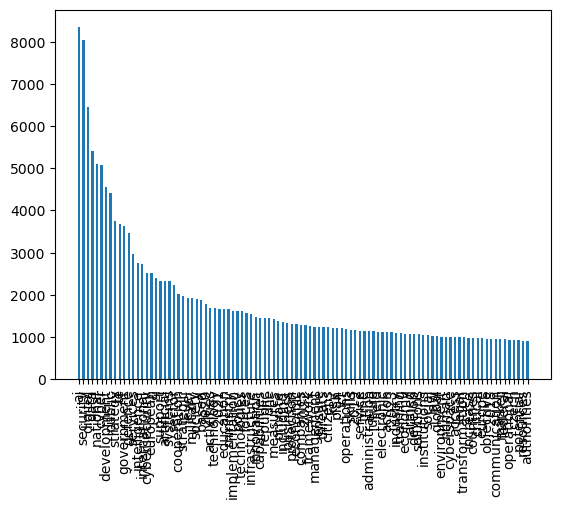

In [13]:
keys = list(word_freqs.keys())
vals = list(word_freqs.values())
plt.bar(keys[:100], vals[:100], align="center", width=0.5)
plt.xticks(rotation=90)
plt.show()

In [3]:
corpus_df = pd.read_csv("./corpus.csv")
cleaned_corpus = corpus_df["Text"].dropna().to_list()

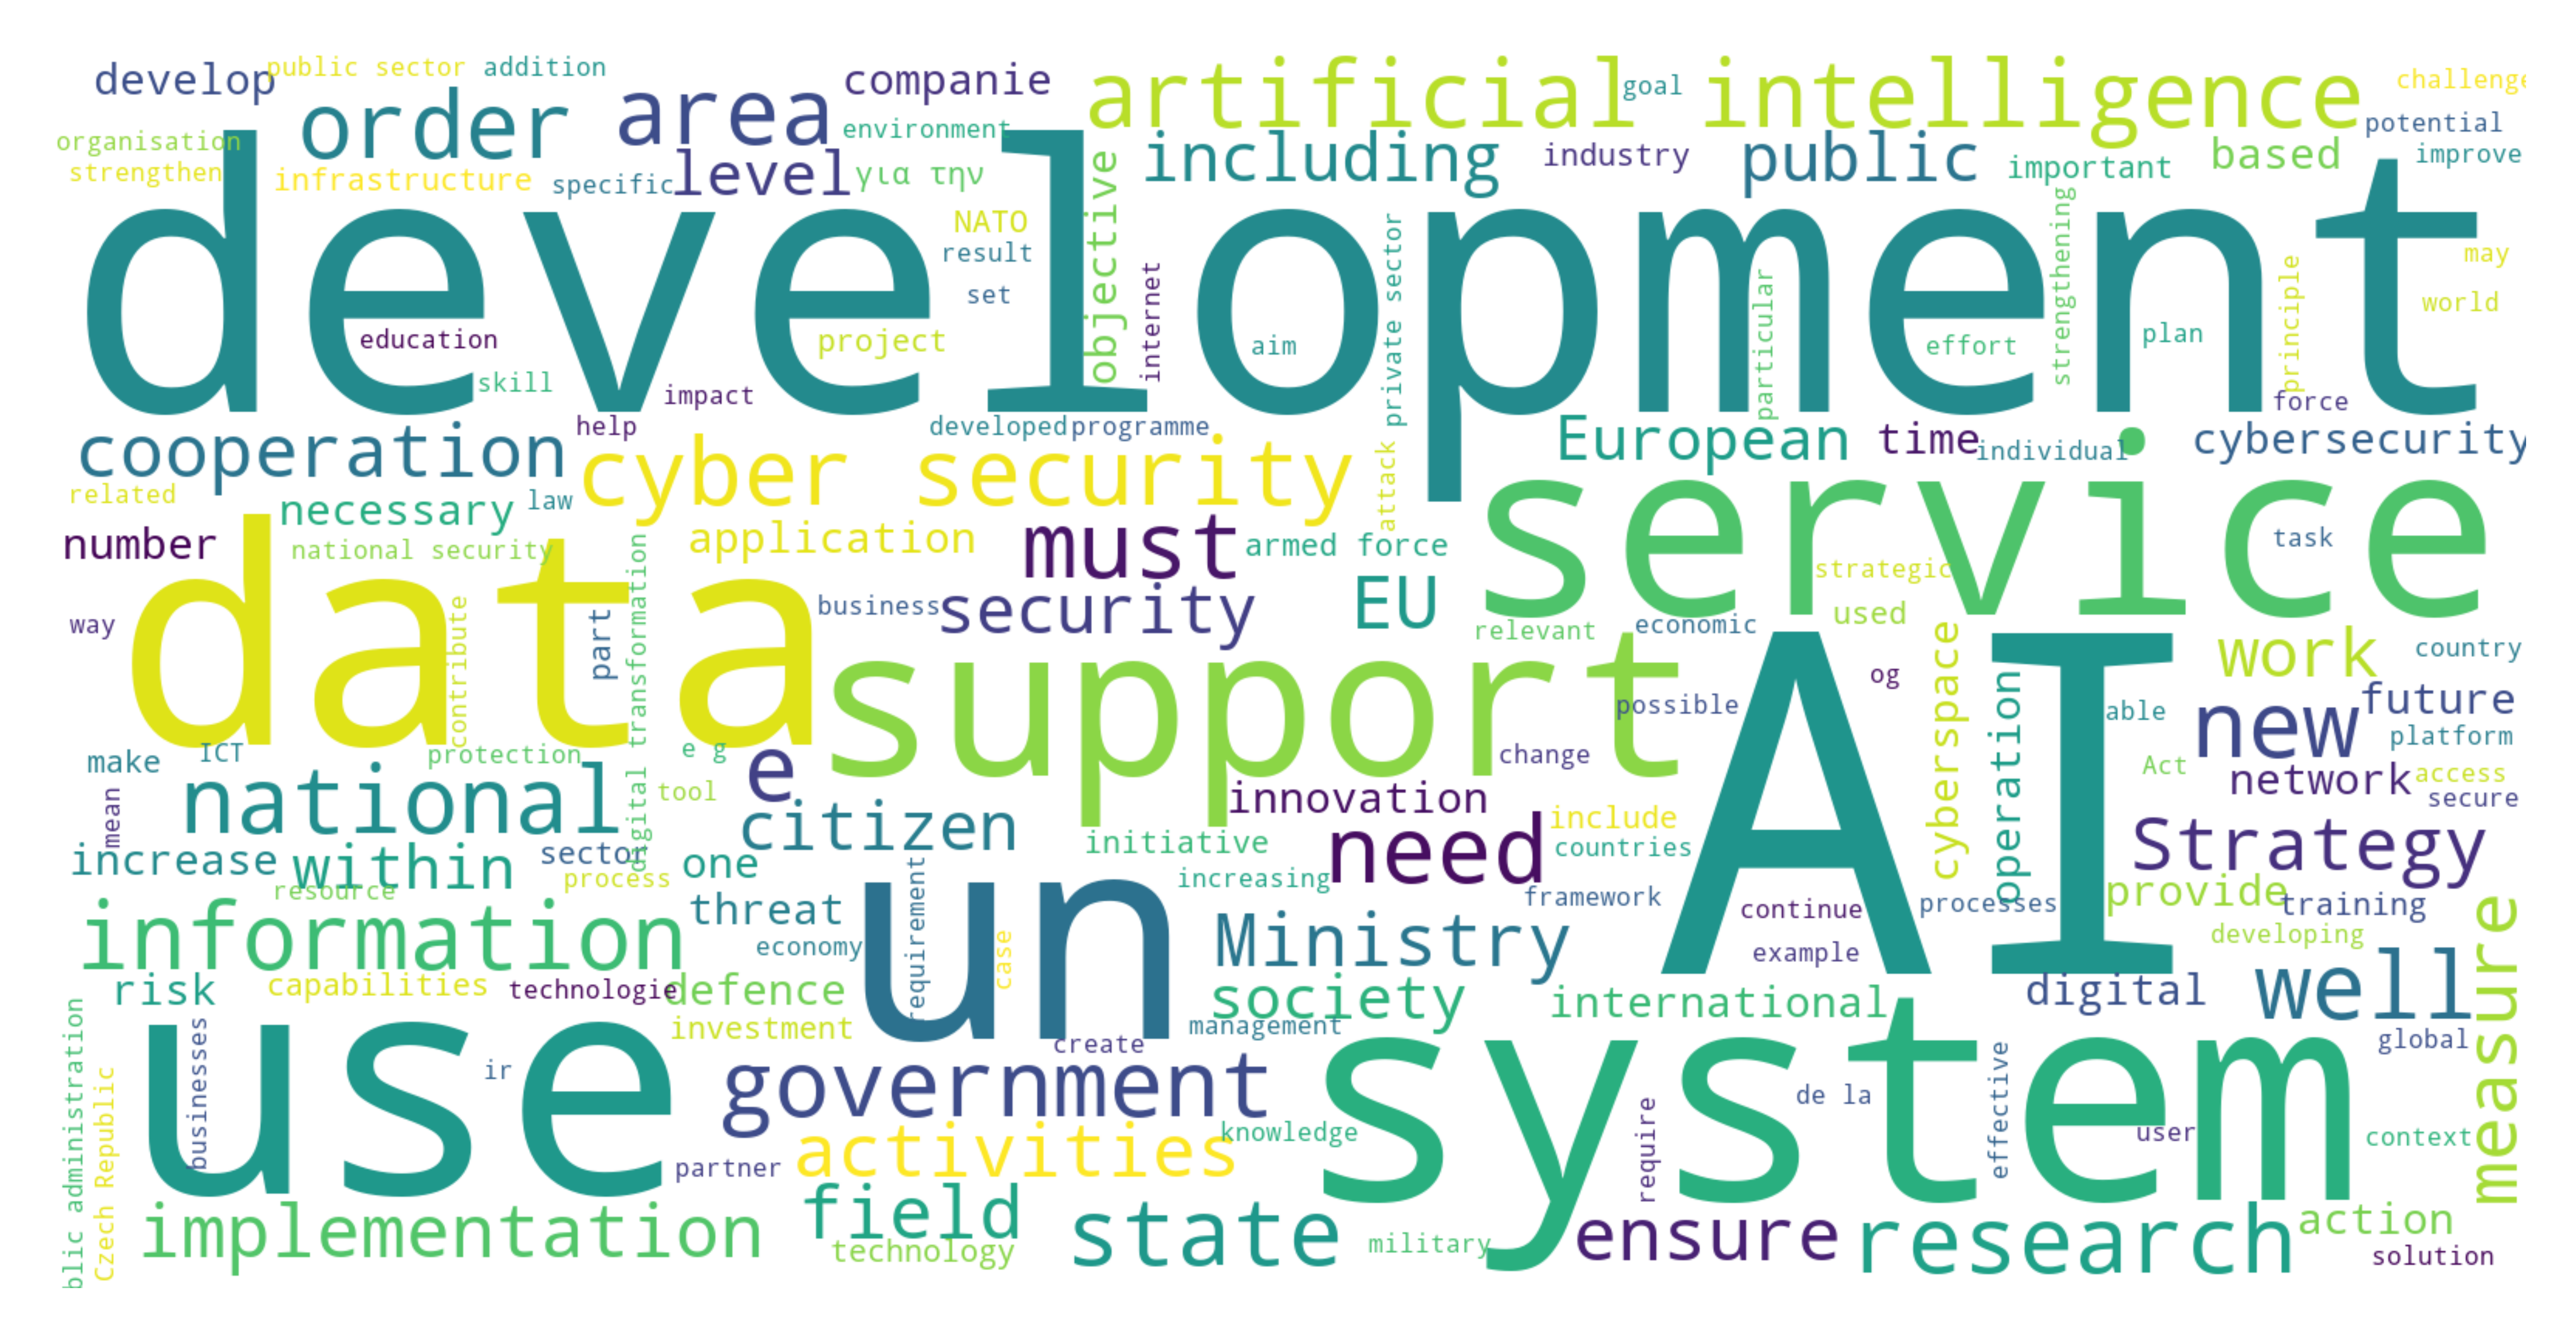

In [16]:
# generate a word cloud
cleaned_corpus_txt = "".join(cleaned_corpus)
cleaned_corpus_txt = cleaned_corpus_txt.replace("will", "")
wordcloud = WordCloud(scale=4, background_color="white").generate(cleaned_corpus_txt)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()